<a href="https://colab.research.google.com/github/jiayuankeliang/309CourseWork2/blob/main/model_implementation_and_reslut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rustin96","key":"0f80a220c3c09d55b32c93025d2c2d3b"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600  ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 606M/612M [00:14<00:00, 42.8MB/s]
100% 612M/612M [00:14<00:00, 42.8MB/s]


In [9]:
import zipfile

filename = '/content/gtsrb-german-traffic-sign.zip'

with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('.')

In [10]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
img_height = 32
img_width = 32

In [21]:
data = []
labels = []
classes = 43

with tf.device('/GPU:0'):
  for i in range(classes):
      path = os.path.join('/content/Train',str(i))
      images = os.listdir(path)

      for image in images:
        image = Image.open(os.path.join(path, image))
        image = image.resize((img_height,img_width))
        image = np.array(image)
        data.append(image)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [23]:
X_train.shape, y_train.shape

((31367, 32, 32, 3), (31367,))

In [24]:
X_val.shape, y_val.shape

((7842, 32, 32, 3), (7842,))

In [25]:
X_train = X_train/255
X_val = X_val/255

In [26]:
plt.figure(figsize=(100, 100))
for i in range(100):
  ax = plt.subplot(10, 10, i + 1)
  plt.imshow(X_train[i])
  plt.title(y_train[i])
  plt.axis("off")

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(43, activation='softmax')
])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                    

In [29]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [30]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

In [31]:
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[checkpoint_callback])

Epoch 1/20
981/981 [==============================] - 22s 8ms/step - loss: 1.2617 - accuracy: 0.6338 - val_loss: 0.0876 - val_accuracy: 0.9773
Epoch 2/20
981/981 [==============================] - 8s 8ms/step - loss: 0.1484 - accuracy: 0.9561 - val_loss: 0.0338 - val_accuracy: 0.9906
Epoch 3/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0778 - accuracy: 0.9776 - val_loss: 0.0300 - val_accuracy: 0.9922
Epoch 4/20
981/981 [==============================] - 7s 7ms/step - loss: 0.0569 - accuracy: 0.9832 - val_loss: 0.0174 - val_accuracy: 0.9969
Epoch 5/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0490 - accuracy: 0.9870 - val_loss: 0.0309 - val_accuracy: 0.9926
Epoch 6/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0468 - accuracy: 0.9877 - val_loss: 0.0163 - val_accuracy: 0.9963
Epoch 7/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0391 - accuracy: 0.9896 - val_loss: 0.0224 - val_accuracy: 0.9959
Epoch

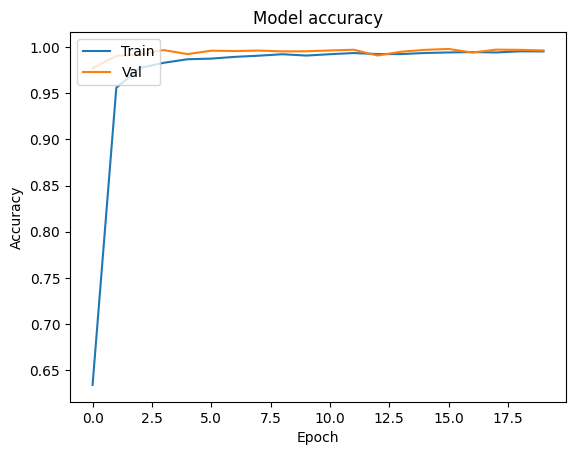

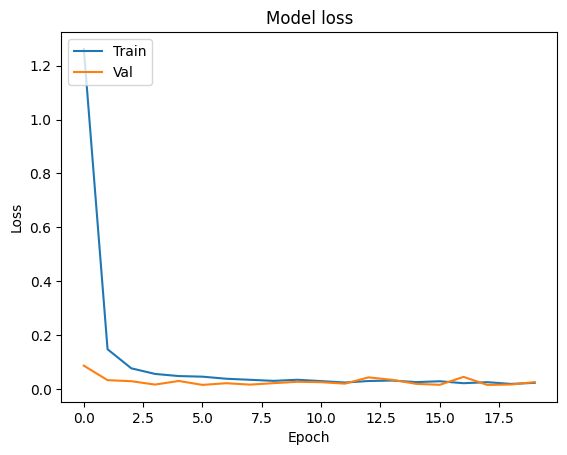

In [32]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [33]:
test = pd.read_csv('/content/Test.csv')

y_test = test["ClassId"].values
imgs = test["Path"].values

data=[]

with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([img_height, img_width])
        data.append(np.array(image))

X_test=np.array(data)

In [34]:
model = tf.keras.models.load_model('best_model.h5')

In [35]:
X_test = X_test/255
model_predict = model.predict(X_test)

correct_predict = []
incorrect_predict = []

for i in range(len(model_predict)):
  label = np.argmax(model_predict[i])
  if label == y_test[i]:
    correct_predict.append(i)
  else:
    incorrect_predict.append(i)

accuracay = len(correct_predict) / (len(correct_predict) + len(incorrect_predict))
print('accuracay: {}'.format(accuracay))

395/395 [==============================] - 1s 3ms/step
accuracay: 0.9771971496437054


ture:22-predict:25


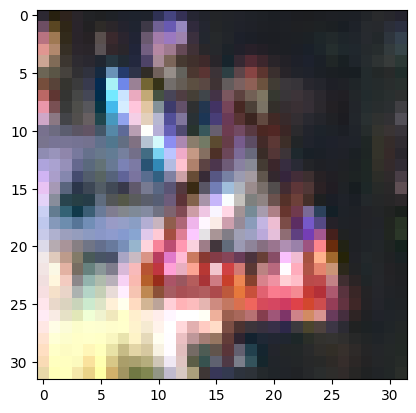

In [60]:
index = 10
index = incorrect_predict[index]
plt.imshow(X_test[index])
print('ture:{}-predict:{}'.format(y_test[index],np.argmax(model_predict[index])))

In [36]:
layer_outputs = [layer.output for layer in model.layers[0:6]]

In [37]:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

1/1 [==============================] - 0s 206ms/step


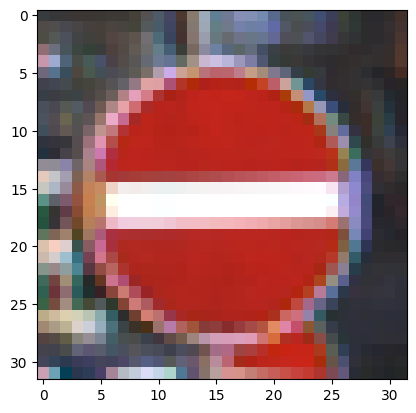

In [38]:
img = X_test[1000]
plt.imshow(img)
img = img.reshape(1, 32, 32, 3)
activations = activation_model.predict(img)

<function matplotlib.pyplot.show(close=None, block=None)>

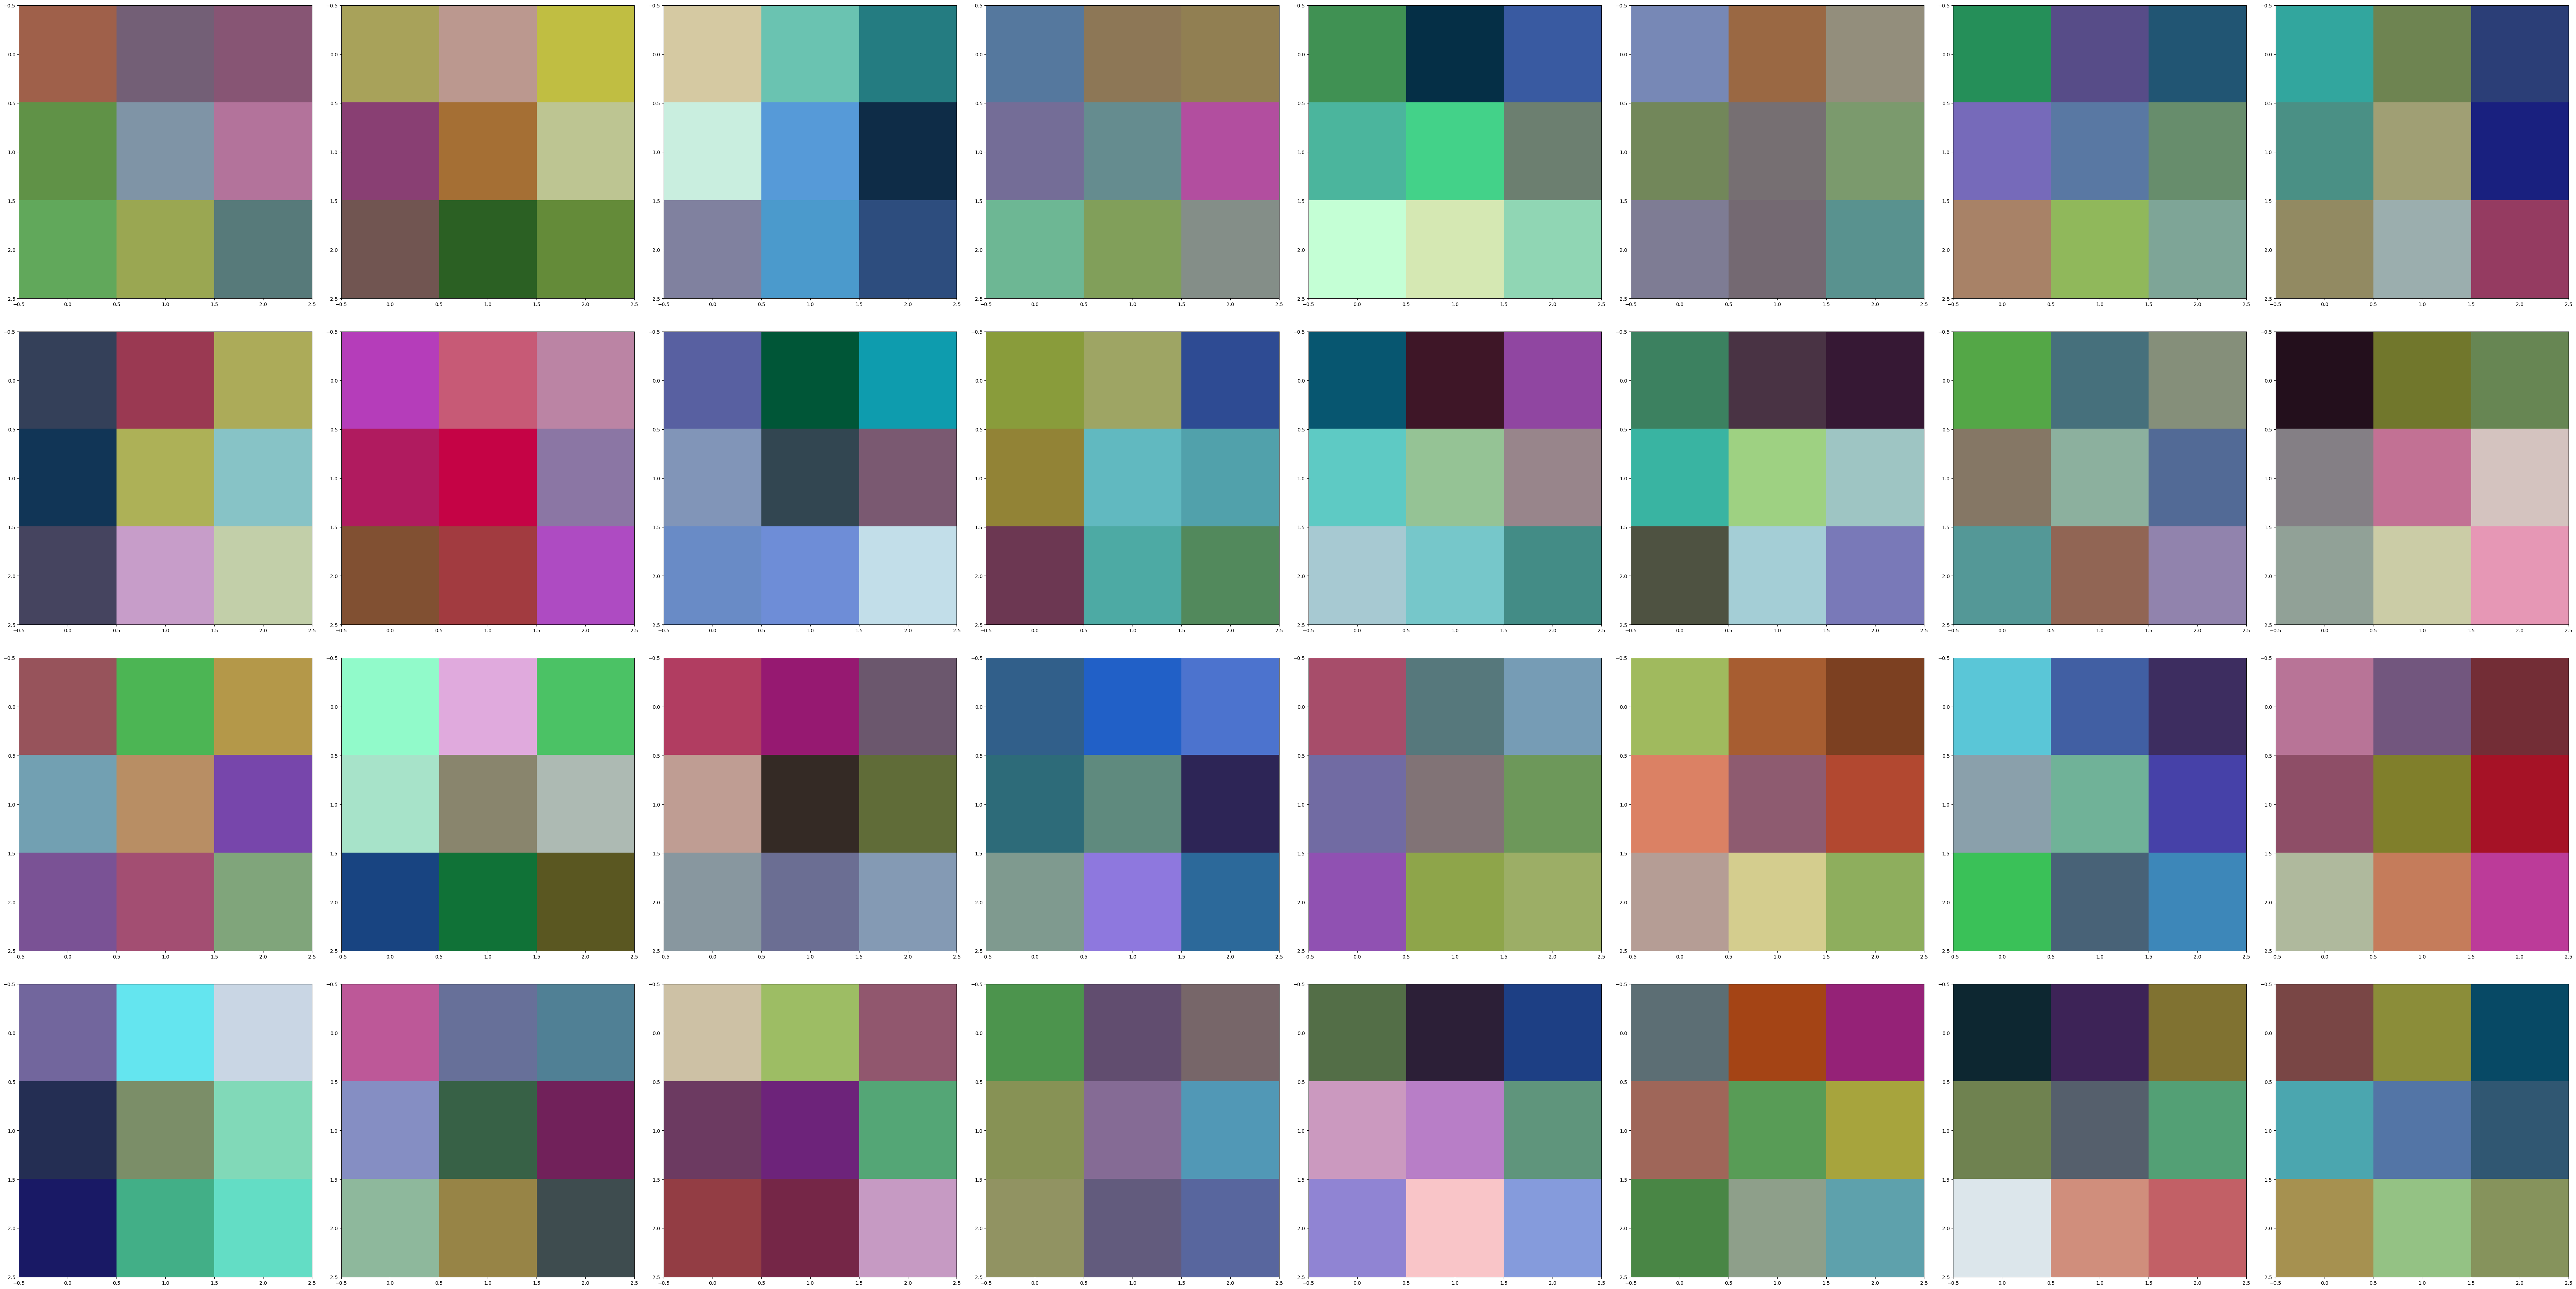

In [41]:
conv_layer = model.get_layer('conv2d')

#get kernel weights
kernel_weights = conv_layer.get_weights()[0]

# normalize weights
kernel_weights_norm = (kernel_weights - np.min(kernel_weights)) / (np.max(kernel_weights) - np.min(kernel_weights))

fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(80, 40))
for i in range(4):
  for j in range(8):
    ax[i, j].imshow(kernel_weights_norm[:,:,:,i*8 + j])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

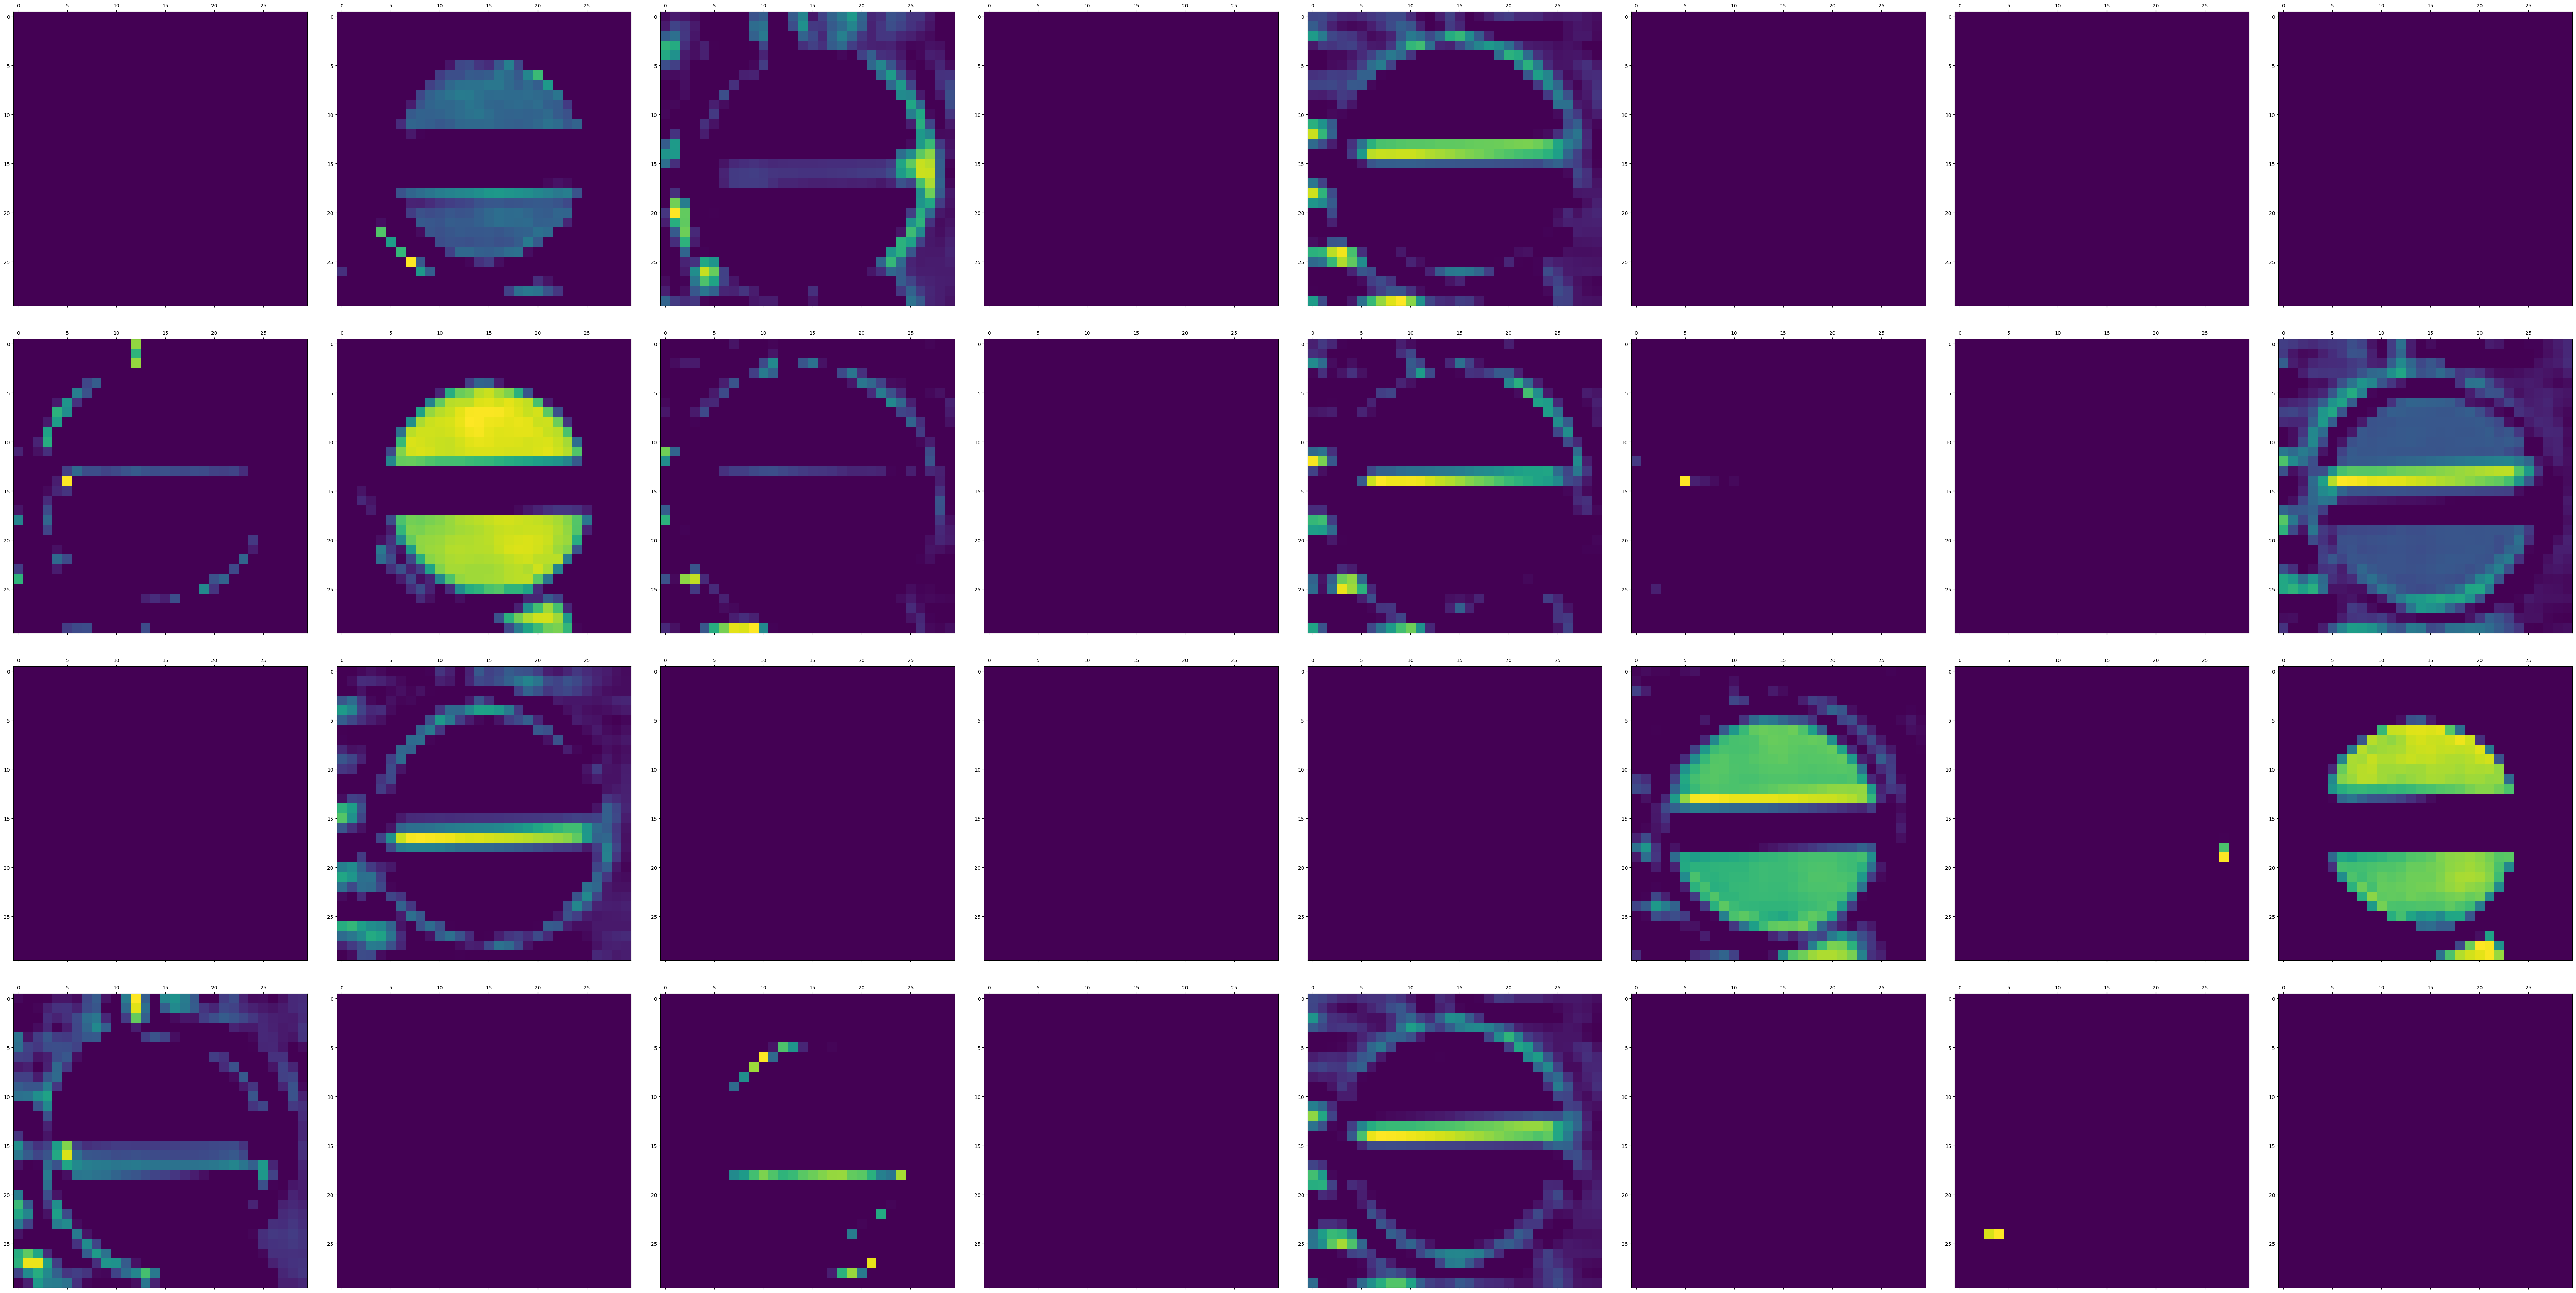

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(80, 40))
for i in range(4):
  for j in range(8):
    ax[i, j].matshow(activations[0][0, :, :, i * 8 + j])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.show

In [43]:
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(80, 80))
for i in range(8):
  for j in range(8):
    ax[i, j].matshow(activations[1][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [44]:
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(80, 80))
for i in range(8):
  for j in range(8):
    ax[i, j].matshow(activations[2][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [45]:
fig, ax = plt.subplots(nrows=16, ncols=8, figsize=(80, 160))
for i in range(16):
  for j in range(8):
    ax[i, j].matshow(activations[3][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [46]:
fig, ax = plt.subplots(nrows=32, ncols=8, figsize=(80, 320))
for i in range(32):
  for j in range(8):
    ax[i, j].matshow(activations[4][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [47]:
fig, ax = plt.subplots(nrows=32, ncols=8, figsize=(80, 320))
for i in range(32):
  for j in range(8):
    ax[i, j].matshow(activations[5][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>